In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml/bin/python
/home/ata/miniconda3/envs/ml/bin/jupyter


In [1]:
import sys
assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-01-12 00:02:29.772554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 00:02:30.091796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736622150.214770   58986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736622150.247638   58986 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 00:02:30.532812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
# from dotenv import load_dotenv
# from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

#### Initialize Binance Client

In [5]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
time_delta = 2
db_name = pair + "_1sec_" + str(time_delta) + "weeks.db"
db_name = "BTCUSDT_1sec_dry_run.db"             # For dry run testing
binance_client = BinanceClient(db_name)
binance_client.set_interval("1s")
batch_feature = BatchFeatures()


#### Fecth Data from Binance

In [6]:

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
# start_date = server_time_dt - timedelta(hours=10)
start_date = server_time_dt - timedelta(days=time_delta)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    df = data
else:
    print("No data found!!!.")

Fetching data from Binance API...


#### Fetch data from db

In [28]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-01-09 17:08:59,94156.00,94156.01,94151.51,94151.51,0.11413
2025-01-09 17:09:00,94151.51,94151.52,94151.51,94151.52,0.00807
2025-01-09 17:09:01,94151.52,94151.52,94151.28,94151.28,0.04019
2025-01-09 17:09:02,94151.28,94151.29,94151.28,94151.28,0.00781
2025-01-09 17:09:03,94151.28,94151.28,94148.78,94148.78,0.04351


Feature engineering

In [29]:
# Feature Engineering (mind the order since some features are depended on others)
bf = BatchFeatures()
bf.calculate_sma(df)
bf.calculate_ema(df)
bf.calculate_rsi(df)
bf.calculate_macd(df)
bf.calculate_bollinger_bands(df)
bf.calculate_atr(df)
bf.calculate_volume_features(df)
bf.calculate_roc(df)
bf.calculate_lagged_features(df)
bf.calculate_candle_features(df)
bf.calculate_stochastic_oscillator(df)
bf.calculate_williams_r(df)
bf.calculate_moving_average_crossover(df)
bf.calculate_historical_volatility(df)
bf.calculate_on_balance_volume(df)
bf.calculate_money_flow_index(df)
bf.calculate_croc(df)

# drop NaNs
df.dropna(inplace=True)

#### Define target 

In [30]:
# Predict the percentage price change over the next 'n' candles
nn = 5
# df['target'] = (df['close'] - df['close'].shift(nn)) / df['close'].shift(nn) * 100
df['target'] = 1 - df['ema_5'].shift(-nn) / df['ema_5']  

for ii in range(1, 2*nn):
    df[f'target_lag_{ii}'] = df['target'].shift(ii)
df.dropna(inplace=True)

#### Test/Train Splot

Split the df into three parts, train, validation and testing

In [27]:
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd

# Define split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Use only the last 3 hours of data for training, validation, and testing
df_recent = df.copy()  # Adjust slice as needed

# Calculate split indices
n = len(df_recent)
train_end = int(train_ratio * n)
val_end = train_end + int(val_ratio * n)

# Perform the splits
train_data = df_recent.iloc[:train_end]
val_data = df_recent.iloc[train_end:val_end]
test_data = df_recent.iloc[val_end:]

# Separate features (X_*) and targets (y_*)
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

X_valid = val_data.drop(columns=['target'])
y_valid = val_data['target']

X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Initialize the scaler and scale only the X_* components
scaler = StandardScaler()

# Fit the scaler on the training features and transform
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Transform validation and test features
X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Save the scaler for later use
joblib.dump(scaler, 'lstm_scaler_ema5_1sec.pkl')

# Combine scaled features (X_*) and unscaled targets (y_*) back into final datasets
# train_data = pd.concat([X_train_scaled, y_train], axis=1)
# valid_data = pd.concat([X_valid_scaled, y_valid], axis=1)
# test_data = pd.concat([X_test_scaled, y_test], axis=1)

# Output lengths of each dataset to verify correctness
# print(f"Train data shape: {train_data.shape}")
# print(f"Validation data shape: {valid_data.shape}")
# print(f"Test data shape: {test_data.shape}")


['lstm_scaler_ema5_1sec.pkl']

Randomize the time sequences

In [10]:
# Sequence length (5 hours = 300 instances for 1-minute resolution)
seq_length = 60
batch_size = 32*30

# Create time series datasets
tf.random.set_seed(42)  # Ensures reproducibility

# Training dataset
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_scaled.iloc[:-seq_length].to_numpy(),  # Exclude the last 'seq_length' rows for input
    targets=y_train.iloc[seq_length:].to_numpy(),  # Shift target by 'seq_length'
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation dataset
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_valid_scaled.iloc[:-seq_length].to_numpy(),
    targets=y_valid.iloc[seq_length:].to_numpy(),
    sequence_length=seq_length,
    batch_size=batch_size
)


I0000 00:00:1736619474.795911   53969 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True)
    # opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    opt=tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

Simple RNN Test

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, input_shape=[None, 56]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation="tanh"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


/home/ata/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, input_shape=[None, 61]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation="tanh"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


/home/ata/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.001)

Epoch 1/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0036 - mae: 0.0578 - val_loss: 5.0738e-05 - val_mae: 0.0078
Epoch 2/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 3.4228e-04 - mae: 0.0201 - val_loss: 2.0473e-06 - val_mae: 0.0015
Epoch 3/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 1.5918e-04 - mae: 0.0137 - val_loss: 5.6212e-07 - val_mae: 8.1222e-04
Epoch 4/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 9.9791e-05 - mae: 0.0108 - val_loss: 3.8418e-07 - val_mae: 6.7623e-04
Epoch 5/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 6.9139e-05 - mae: 0.0090 - val_loss: 3.3848e-07 - val_mae: 6.5673e-04
Epoch 6/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5.2260e-05 - mae: 0.0079 - val_loss: 3.4763e-07 - val_mae: 6.8871e-04
Epoch 7/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4.0171e-05 - mae: 0.0069 - val_loss: 3.1909e-07 - val_mae: 6.4908e-04
Epoch 8/500
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.2213e-05 - mae: 0.0062 -

0.00025586888659745455

Save the trtained model

In [21]:
# Save the model
joblib.dump(model, 'lstm_10candles_1sec_ema5.joblib')

['lstm_10candles_1sec_ema5.joblib']

Load previously trained model

In [13]:
# load the best model
model = joblib.load('lstm_10candles_1sec_ema5.joblib')

In [14]:
print(f"Target abs mean: {y_test.abs().mean()}")
print(f"Target std deviation: {y_test.std()}")
print(f"Target min: {y_test.min()}")
print(f"Target max: {y_test.max()}")


Target abs mean: 5.247532953971946e-05
Target std deviation: 9.213645959264123e-05
Target min: -0.0009851342000504193
Target max: 0.0009541567941674378


In [19]:
INITIAL_BALANCE=1000

In [15]:

# Generate sequences for LSTM input
# seq_length = 60  # Replace with the sequence length used during training
X_test_copy = X_test_scaled.copy()
y_test_copy = y_test.copy()
X_test_list = []
y_test_list = []

for i in range(seq_length, len(test_data)-nn):
    X_test_list.append(X_test_copy.iloc[i-seq_length:i])  # Create sequence
    y_test_list.append(y_test_copy.iloc[i])
    # y_test.append( (test_data.iloc[i + nn]['close'] - test_data.iloc[i]['close']) / test_data.iloc[i]['close'] * 100)  # Price change nn candles ahead

X_test_list = np.array(X_test_list)
y_test_list = np.array(y_test_list)

# Unscale predictions
predictions = model.predict(X_test_list)  # Predictions are in scaled space
predictions = predictions.flatten()

# Prepend 'nn' NaNs to align predictions with actual changes
predictions = np.concatenate((predictions, np.full(nn, np.nan)))
# predictions = -1*predictions 

# Combine predictions and actual values
results_df = X_test[seq_length:].copy()

# Calculate predicted price
results_df['Predictions'] = predictions
results_df['predicted_ema_5'] = results_df['ema_5'] * (1 + results_df['Predictions']/100)



  11/1077 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step    

I0000 00:00:1736619497.850299   54184 cuda_dnn.cc:529] Loaded cuDNN version 90300


1077/1077 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [17]:
def simulate_trades(signals, prices, initial_balance=1000):
    """
    Simulates trades based on signals and actual price changes.

    Args:
        actual_changes (list or pd.Series): Actual percentage changes (not predicted).
        signals (list): List of trading signals ("Buy", "Sell", "Hold").
        prices (list or pd.Series): Actual price values for the asset.
        initial_balance (float): Starting balance of the trading account.

    Returns:
        float: Final balance or cumulative profit.
    """
    balance = INITIAL_BALANCE
    position = 0  # Tracks the number of stocks held
    entry_price = None  # Store the price when a "Buy" was executed

    for i, signal in enumerate(signals):
        if signal == 1 and balance > 0:
            # Execute a buy
            entry_price = prices.iloc[i]  # Use .iloc for positional indexing
            position = balance / entry_price  # Buy with all available balance
            balance = 0  # All balance used to buy
        elif signal == -1 and position > 0:
            # Execute a sell
            exit_price = prices.iloc[i]  # Use .iloc for positional indexing
            balance = position * exit_price  # Convert position to cash
            position = 0  # Clear position
            entry_price = None  # Reset entry price after selling

    # If there's a remaining position at the end, calculate its value
    if position > 0 and entry_price is not None:
        balance += position * prices.iloc[-1]  # Use .iloc for positional indexing

    return balance - INITIAL_BALANCE  # Return cumulative profit


In [16]:
predict_ch_min = results_df['Predictions'].dropna().min()
predict_ch_max = results_df['Predictions'].dropna().max()
print(f'Min Change: {predict_ch_min}')
print(f'Max Change: {predict_ch_max}')

Min Change: -0.027803899720311165
Max Change: 0.09597020596265793


In [22]:
# Define buy and sell thresholds (e.g., absolute differences in predicted vs. actual price)
buy_thresholds = np.arange(predict_ch_min, -0.01, 0.05)  # Thresholds for when to "Sell"; Sell when price is predicted to go down
sell_thresholds = np.arange(0.001, predict_ch_max, 0.0005)   # Thresholds for when to "Buy"; buy when price is predicted to go up

best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))
# -1 = Sell
# 0 = Hold
# 1 = Buy
for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            -1 if pred > sell_th else 1 if pred < buy_th else 0
            for pred in predictions
        ]

        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['close'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


Best Buy Threshold: -0.027803899720311165, Best Sell Threshold: 0.001
Best Performance: 0.0


#### Beck Testing 

In [63]:
results_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'sma_10', 'sma_50', 'ema_5',
       'ema_10', 'ema_50', 'rsi_14', 'rsi_14_smoothed', 'macd', 'macd_signal',
       'macd_hist', 'macd_hist_smoothed', 'macd_fast', 'macd_fast_signal',
       'macd_fast_hist', 'bollinger_upper_20', 'bollinger_lower_20',
       'bollinger_middle_20', 'atr_14', 'volume_ma_20', 'volume_ratio',
       'roc_5', 'roc_10', 'roc_20', 'roc_10_smoothed', 'close_lag_1',
       'close_lag_3', 'close_lag_5', 'close_lag_7', 'close_lag_9',
       'close_lag_11', 'macd_lag_1', 'candle_body', 'upper_wick', 'lower_wick',
       'stochastic_oscillator', 'stochastic_oscillator_slow', 'williams_r',
       'williams_r_smoothed', 'sma_short', 'sma_long', 'ma_crossover',
       'log_return', 'historical_volatility', 'price_change', 'obv', 'mfi',
       'croc_10', 'target_lag_1', 'target_lag_2', 'target_lag_3',
       'target_lag_4', 'target_lag_5', 'target_lag_6', 'target_lag_7',
       'target_lag_8', 'target_lag_9', 'Prediction

In [23]:
# Static threshold
best_buy_threshold = -0.027803899720311165
best_sell_threshold = 0.001

buy_threshold = best_buy_threshold
sell_threshold = best_sell_threshold

# Generate signals with corrected logic
trading_signals = [
    -1 if pred > sell_threshold else 1 if pred < buy_threshold else 0
    for pred in results_df['Predictions']
]



# # Define the multiplier for dynamic thresholds
# k = 8  # Adjust based on your backtesting results

# # Calculate ATR-based percentage thresholds
# results_df['atr_percentage'] = (results_df['atr_14'] / results_df['ema_5']) * 100  # ATR as % of EMA-5
# results_df['sell_threshold'] = k * results_df['atr_percentage']
# results_df['buy_threshold'] = -k * results_df['atr_percentage']


# results_df['buy_signal'] = results_df['close'] < results_df['bollinger_lower_20']
# results_df['sell_signal'] = results_df['close'] > results_df['bollinger_upper_20']


# k = 500  # Multiplier for historical volatility
# results_df['sell_threshold'] = k * results_df['historical_volatility']
# results_df['buy_threshold'] = -k * results_df['historical_volatility']

# results_df['dynamic_buy_threshold'] = (results_df['atr_14'] + results_df['historical_volatility']) / 2
# results_df['dynamic_sell_threshold'] = -(results_df['atr_14'] + results_df['historical_volatility']) / 2


# # Define buy & sell thrsholds
# buy_threshold = results_df['buy_threshold']
# sell_threshold = results_df['sell_threshold']

# # Generate signals 
# trading_signals = [
#     -1 if pred > sell_threshold[i] else 1 if pred < buy_threshold[i] else 0
#     for i, pred in enumerate(results_df['Predictions'].values)
# ]


balance = INITIAL_BALANCE
position = 0  # No stock initially
trading_log = []  # To store completed trades

results_df['Signal'] = trading_signals

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
# results_df['open'] = df.loc[results_df.index, 'open']
# results_df['close'] = df.loc[results_df.index, 'close']

results_df.dropna(inplace=True)

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['close']  # Use 'open' price for Buy

    if signal == 1 and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = balance / price
        position = buy_volume  # Update position
        balance = 0  # All money is invested

    elif signal == -1 and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = price  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['close']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - INITIAL_BALANCE:.2f}")



Final Balance: $1000.00
Net Profit: $0.00


In [50]:
trading_log_df.head()

,Buy Date,Buy Price,Buy Volume,Sell Date,Sell Price,Profit/Loss
0,2024-12-30 21:45:00,92386.81,0.010824,2024-12-31 08:32:00,94656.99,24.572555
1,2024-12-31 17:40:00,93446.68,0.010964,2025-01-06 14:49:00,100489.99,77.224596
2,2025-01-09 02:12:00,93639.18,0.011766,2025-01-09 16:55:00,94274.02,7.469789


In [109]:
# Define the range for scaling based on Actual Change
target_min = results_df[['close', 'predicted_ema_5']].min().min()
target_max = results_df[['close', 'predicted_ema_5']].max().max()

# Scale Close to the same range as the target
close_min = results_df['close'].min()
close_max = results_df['close'].max()

results_df['Scaled Close'] = 2* (results_df['close'] - close_min) / (close_max - close_min) # * (target_max - target_min) + target_min


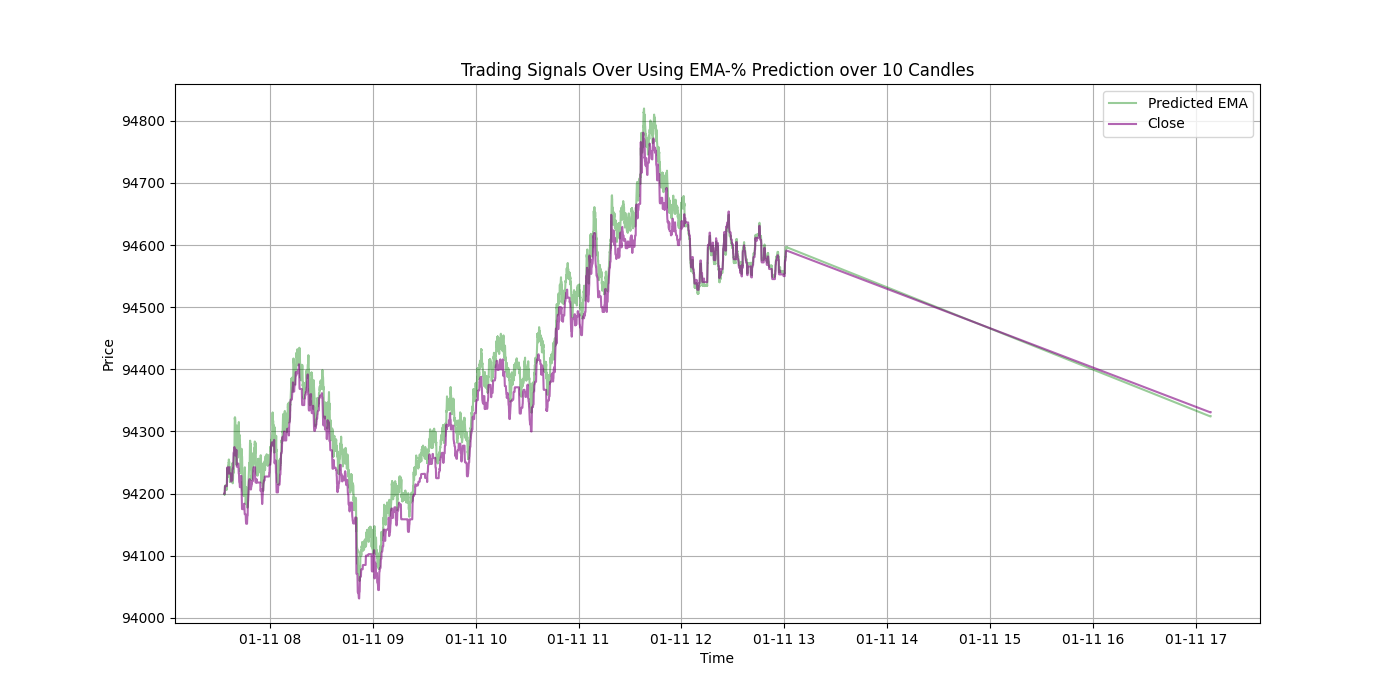

In [25]:
# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
# plt.plot(results_df.index, results_df['ema_5'], label='EMA-5', color='blue', alpha=0.4)
plt.plot(results_df.index, results_df['predicted_ema_5'], label='Predicted EMA', color='green', alpha=0.4)
plt.plot(results_df.index, results_df['ema_5'], label='Close', color='purple', alpha=0.6)


# # Use trading_log_df for Buy and Sell points
# buy_signals = trading_log_df.dropna(subset=['Buy Date'])
# sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# # Map Buy/Sell signals to values from results_df['close']
# buy_close_prices = [results_df.loc[row['Buy Date'], 'close'] for _, row in buy_signals.iterrows()]
# sell_close_prices = [results_df.loc[row['Sell Date'], 'close'] for _, row in sell_signals.iterrows()]

# # Plot Buy signals as green squares at actual 'close' prices
# plt.scatter(
#     buy_signals['Buy Date'],
#     buy_close_prices,
#     label='Buy Signal',
#     color='green',
#     marker='^',
#     alpha=0.6
# )

# # Plot Sell signals as red circles at actual 'close' prices
# plt.scatter(
#     sell_signals['Sell Date'],
#     sell_close_prices,
#     label='Sell Signal',
#     color='red',
#     marker='v',
#     alpha=0.6
# )



# # Add buy and sell thresholds
# plt.axhline(y=results_df['ema_5'].mean()*(1+buy_threshold/100), color='green', linestyle='--', label='Buy Threshold', alpha=0.9)
# plt.axhline(y=results_df['ema_5'].mean()*(1+sell_threshold/100), color='red', linestyle='--', label='Sell Threshold', alpha=0.9)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Using EMA-% Prediction over 10 Candles")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


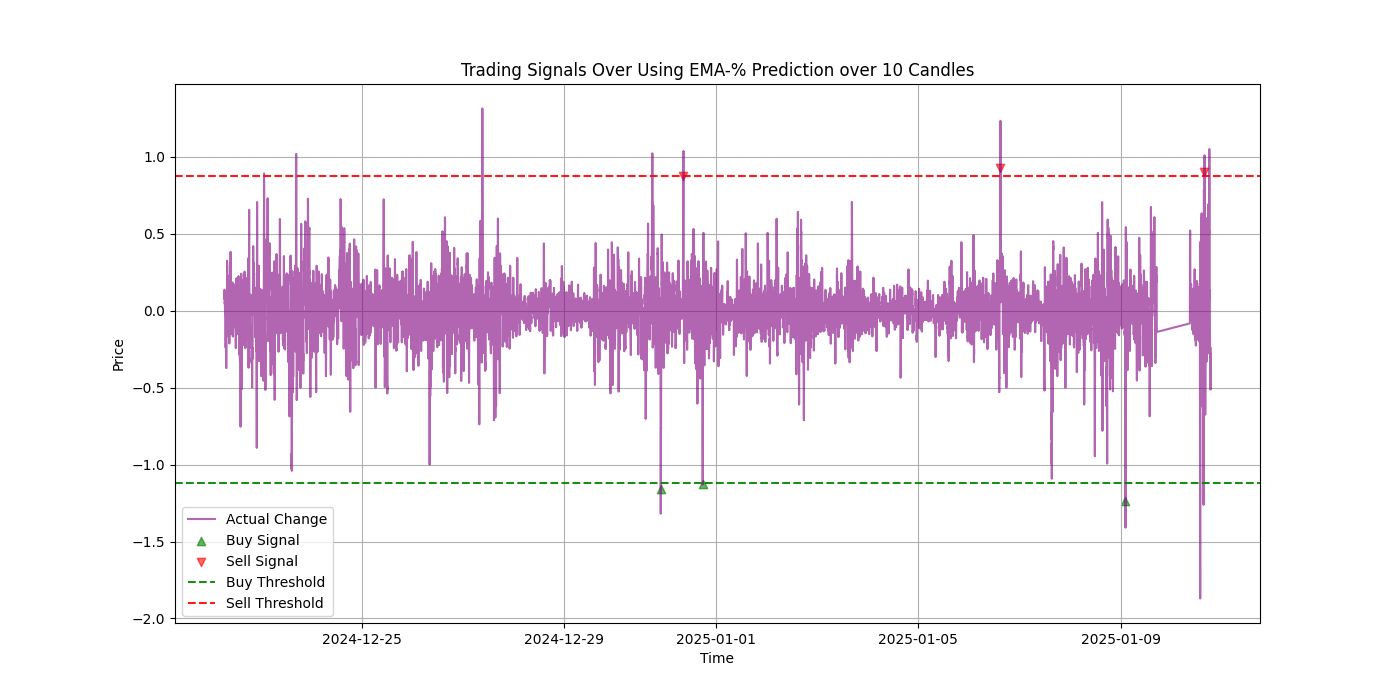

In [118]:
# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predictions'], label='Actual Change', color='purple', alpha=0.6)


# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predictions'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predictions'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='^',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='v',
    alpha=0.6
)



# Add buy and sell thresholds
plt.axhline(y=buy_threshold, color='green', linestyle='--', label='Buy Threshold', alpha=0.9)
plt.axhline(y=sell_threshold, color='red', linestyle='--', label='Sell Threshold', alpha=0.9)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Using EMA-% Prediction over 10 Candles")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.clf()
plt.Figure(figsize=[12,6])
# results_df['Predictions'].plot()
# Add buy and sell thresholds
plt.plot(results_df['buy_threshold'] , color='green', linestyle='--', label='buy threshold', alpha=0.6)
plt.plot(results_df['sell_threshold'] , color='red', linestyle='--', label='sell threshold', alpha=0.6)
plt.plot(results_df['Predictions'] , color='blue', linestyle='--', label='Predictions', alpha=0.3)
plt.plot(results_df['Scaled Close'], label='Scaled Close', color='blue', linestyle='--', alpha=0.8)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Scaled Close'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Scaled Close'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='^',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='v',
    alpha=0.6
)

plt.legend()
plt.show()

KeyError: 'buy_threshold'